In [1]:
import numpy as np
import healpy as hp
from astropy import units as u
from astropy import constants as const
from astropy.io import fits
from astropy_healpix import HEALPix
from astropy.coordinates import FK5, Galactic
from astropy.wcs import WCS

# I. AME Maps


### Read in the Commander AME maps
Note that there are three fit parameters:
* Amplitude of component 1 (A1)
* Peak frequency of component 1 (nu_p1)
* Amplitude of component 2 (A2)

The fits file also includes a frequency template for converting the parameters into an AME SED. This consists of two equal length arrays:
* Frequencies (nu_template)
* I_nu/NH value (MJy cm<sup>2</sup>/sr/H)

In [17]:
# Download external data:
download = True
if download:
    # Planck: AME Foreground map
#    !wget -O COM_CompMap_AME-commander_0256_R2.00.fits "http://pla.esac.esa.int/pla/aio/product-action?MAP.MAP_ID=COM_CompMap_AME-commander_0256_R2.00.fits"

    # Planck: Fit parameters from the Draine & Li thermal dust emission modelling
#    !wget -O COM_CompMap_Dust-DL07-Parameters_2048_R2.00.fits "http://pla.esac.esa.int/pla/aio/product-action?MAP.MAP_ID=COM_CompMap_Dust-DL07-Parameters_2048_R2.00.fits"
    
    # Planck: Thermal dust emission map at 353 GHz from GNILC
#    !wget -O COM_CompMap_Dust-GNILC-F353_2048_R2.00.fits "http://pla.esac.esa.int/pla/aio/product-action?MAP.MAP_ID=COM_CompMap_Dust-GNILC-F353_2048_R2.00.fits"
    
    # Planck: Dust radiance map from GNILC
#    !wget -O COM_CompMap_Dust-GNILC-Radiance_2048_R2.00.fits "http://pla.esac.esa.int/pla/aio/product-action?MAP.MAP_ID=COM_CompMap_Dust-GNILC-Radiance_2048_R2.00.fits"
    
    # NHI map from HI4Pi, via Lenz et al. 2017
#    !wget -O mom0_-90_90_1024.hpx.fits https://dataverse.harvard.edu/api/access/datafile/:persistentId?persistentId=doi:10.7910/DVN/AFJNWJ/RHVAKC

    # fPAH map and mask from Hensley et al. 2016
    !wget -O fpah_map.fits https://dataverse.harvard.edu/api/access/datafile/5370783
    !wget -O fpah_mask.fits https://dataverse.harvard.edu/api/access/datafile/4950635

    # fCNM map 
    !wget -O fcnm_hi4pi_hpx.fits https://dataverse.harvard.edu/api/access/datafile/5618515
    
    # RHI map
    !wget -O rhi_hi4pi_hpx.fits https://dataverse.harvard.edu/api/access/datafile/5618517

                

--2021-12-10 12:37:35--  http://pla.esac.esa.int/pla/aio/product-action?MAP.MAP_ID=COM_CompMap_Dust-GNILC-Radiance_2048_R2.00.fits
Resolving pla.esac.esa.int (pla.esac.esa.int)... 193.147.153.153
Connecting to pla.esac.esa.int (pla.esac.esa.int)|193.147.153.153|:80... connected.
HTTP request sent, awaiting response... 200 
Length: unspecified [image/fits]
Saving to: ‘COM_CompMap_Dust-GNILC-Radiance_2048_R2.00.fits’

COM_CompMap_Dust-GN     [               <=>  ] 192.01M  7.38MB/s    in 32s     

2021-12-10 12:38:08 (5.91 MB/s) - ‘COM_CompMap_Dust-GNILC-Radiance_2048_R2.00.fits’ saved [201337920]

--2021-12-10 12:38:08--  https://dataverse.harvard.edu/api/access/datafile/5370783
Resolving dataverse.harvard.edu (dataverse.harvard.edu)... 50.16.167.217, 52.86.2.73, 100.24.151.143
Connecting to dataverse.harvard.edu (dataverse.harvard.edu)|50.16.167.217|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://dvn-cloud.s3.amazonaws.com/10.7910/DVN/BJVSNZ/1

In [4]:
(A1, nu_p1) = hp.read_map('COM_CompMap_AME-commander_0256_R2.00.fits', hdu=1, field=[1,4],
                      verbose=False)
A1 *= u.uK
nu_p1 *= u.GHz
A2 = hp.read_map('COM_CompMap_AME-commander_0256_R2.00.fits', hdu=2, field=1,
                      verbose=False)
A2 *= u.uK

hdu = fits.open('COM_CompMap_AME-commander_0256_R2.00.fits')
data = hdu[3].data
nu_template = np.array([i[0] for i in data])*u.GHz
Inu_template = np.array([i[1] for i in data])*u.Jy*u.cm**2/u.sr

/Users/clairemurray/anaconda3/lib/python3.8/site-packages/healpy/fitsfunc.py:368: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(


### Convert from Parameters to SED
This function takes the maps of fit parameters and converts to the specified frequency nu.

In [5]:
def I_AME(nu, A1, A2, nu_p1, nu_template, Inu_template):
    # Fixed parameters
    nu0_1 = 22.8*u.GHz
    nu0_2 = 41.0*u.GHz
    nu_p0 = 30.0*u.GHz
    nu_p2 = 33.35*u.GHz
    
    comp1 = A1*(nu0_1/nu)**2*np.interp(nu*nu_p0/nu_p1, nu_template, Inu_template)/ \
        np.interp(nu0_1*nu_p0/nu_p1, nu_template, Inu_template)
    comp2 = A2*(nu0_2/nu)**2*np.interp(nu*nu_p0/nu_p2, nu_template, Inu_template)/ \
        np.interp(nu0_2*nu_p0/nu_p2, nu_template, Inu_template)
    
    total = (comp1 + comp2)*(2.*nu**2*const.k_B)/(const.c**2*u.sr)
    
    return total

### Compute Key Quantities
We use select derived quantities in our analysis. This code computes them and converts to NSIDE=128 from the initial NSIDE=256. Note that ratios are computed by downgrading numerator and denominator before dividing, rather than downgrading a map of the ratio itself.

In [6]:
I_AME_20 = I_AME(20.*u.GHz, A1, A2, nu_p1, nu_template, Inu_template)
I_AME_30 = I_AME(30.*u.GHz, A1, A2, nu_p1, nu_template, Inu_template)

int_Inu = 0.
int_nuInu = 0.

for i in range(1,len(nu_template)):
    dnu = nu_template[i] - nu_template[i-1]
    val = 0.5*(I_AME(nu_template[i], A1, A2, nu_p1, nu_template, Inu_template)+
               I_AME(nu_template[i-1], A1, A2, nu_p1, nu_template, Inu_template))*dnu
    int_Inu += val
    int_nuInu += val*nu_template[i]
    
I_AME_20_128 = hp.ud_grade(I_AME_20.to(u.MJy/u.sr).value, 128)
I_AME_30_128 = hp.ud_grade(I_AME_30.to(u.MJy/u.sr).value, 128)
nu_weighted_128 = hp.ud_grade(int_nuInu.to(u.GHz**2*u.MJy/u.sr).value, 128)/\
    hp.ud_grade(int_Inu.to(u.GHz*u.MJy/u.sr).value, 128)

### Write to files

In [7]:
hp.write_map('I_AME_20GHz.fits', I_AME_20_128, overwrite=True)
hp.write_map('I_AME_30GHz.fits', I_AME_30_128, overwrite=True)
hp.write_map('nu_weighted_AME.fits', nu_weighted_128, overwrite=True)

/Users/clairemurray/anaconda3/lib/python3.8/site-packages/healpy/fitsfunc.py:197: FutureWarning: The default dtype of write_map() will change in a future version: explicitly set the dtype if it is important to you
  warnings.warn(


# II. qPAH Map

### Read in the Planck qPAH and Sigma_d maps
We use both the qPAH and Sigma_dust maps.

In [8]:
(qPAH, Sigma_d) = hp.read_map('COM_CompMap_Dust-DL07-Parameters_2048_R2.00.fits',
                            field=[2,0], verbose=False)

/Users/clairemurray/anaconda3/lib/python3.8/site-packages/healpy/fitsfunc.py:426: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))


### Smooth the Maps
We want an output map with 1 degree resolution. The input maps have 5' resolution

In [9]:
fwhm_in = (5./60.)*np.pi/180. # 5' in radians
fwhm_out = 1.*np.pi/180. # 1 deg in radians
fwhm_smooth = np.sqrt(fwhm_out**2 - fwhm_in**2)

Sigma_PAH = hp.smoothing(Sigma_d*qPAH, fwhm_smooth)
Sigma_d = hp.smoothing(Sigma_d, fwhm_smooth)

/Users/clairemurray/anaconda3/lib/python3.8/site-packages/healpy/sphtfunc.py:822: UserWarning: Sigma is 25.391029 arcmin (0.007386 rad) 
  warnings.warn(
/Users/clairemurray/anaconda3/lib/python3.8/site-packages/healpy/sphtfunc.py:827: UserWarning: -> fwhm is 59.791304 arcmin
  warnings.warn(
/Users/clairemurray/anaconda3/lib/python3.8/site-packages/healpy/sphtfunc.py:822: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  warnings.warn(
/Users/clairemurray/anaconda3/lib/python3.8/site-packages/healpy/sphtfunc.py:827: UserWarning: -> fwhm is 0.000000 arcmin
  warnings.warn(


### Downgrade the maps
These maps are NSIDE=2048, and we need NSIDE=128. Since qPAH is a ratio, we construct Sigma_PAH and downgrade, then take the ratio with the downgraded Sigma_d map.

/Users/clairemurray/anaconda3/lib/python3.8/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/Users/clairemurray/anaconda3/lib/python3.8/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under(bgcolor)
/Users/clairemurray/anaconda3/lib/python3.8/site-packages/healpy/projaxes.py:922: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will 

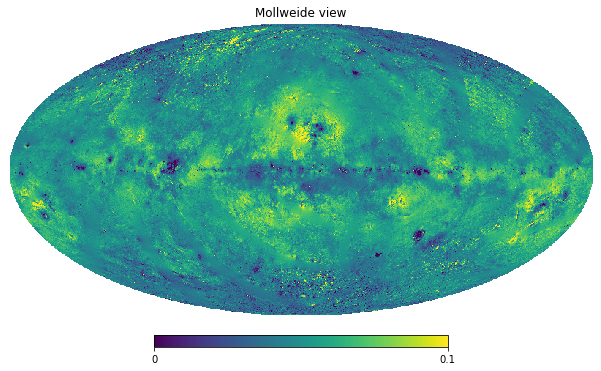

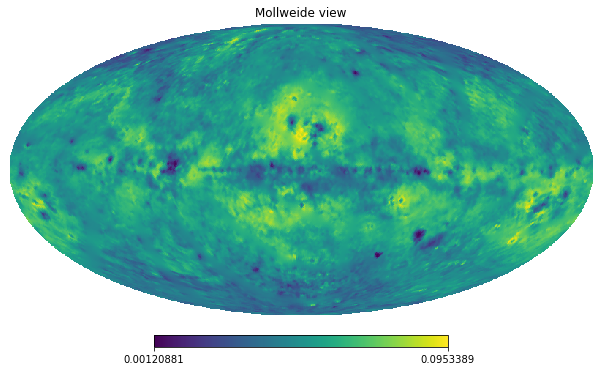

In [10]:
Sigma_PAH_128 = hp.ud_grade(Sigma_PAH,128)
Sigma_d_128 = hp.ud_grade(Sigma_d,128)
qPAH_128 = Sigma_PAH_128/Sigma_d_128

hp.mollview(qPAH)
hp.mollview(qPAH_128)

### Write to file

In [11]:
hp.write_map('qPAH.fits', qPAH_128, overwrite=True)

/Users/clairemurray/anaconda3/lib/python3.8/site-packages/healpy/fitsfunc.py:197: FutureWarning: The default dtype of write_map() will change in a future version: explicitly set the dtype if it is important to you
  warnings.warn(


# III. I_353 Map

### Read in GNILC 2015 map

In [12]:
I_353 = hp.read_map('COM_CompMap_Dust-GNILC-F353_2048_R2.00.fits', verbose=False)

/Users/clairemurray/anaconda3/lib/python3.8/site-packages/healpy/fitsfunc.py:368: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(


### Apply monopole corrections
Note that the map is natively in units of MJy/sr. The monopole correction factors are given in units of uK_CMB. We convert units using 287.5 MJy/sr/K<sub>CMB</sub>.

In [13]:
I_353 += (-452. + 36. + 27.)*1.e-6*287.5

### Smooth map to 1 degree resolution
Note that the GNILC map is multi-resolution, so we choose the lowest resolution of 21.8' corresponding to diffuse, high latitude sightlines.

In [14]:
fwhm_in = (21.8/60.)*np.pi/180. # 21.8' in radians
fwhm_out = 1.*np.pi/180. # 1 deg in radians
fwhm_smooth = np.sqrt(fwhm_out**2 - fwhm_in**2)

I_353 = hp.smoothing(I_353, fwhm_smooth)

/Users/clairemurray/anaconda3/lib/python3.8/site-packages/healpy/sphtfunc.py:822: UserWarning: Sigma is 23.738354 arcmin (0.006905 rad) 
  warnings.warn(
/Users/clairemurray/anaconda3/lib/python3.8/site-packages/healpy/sphtfunc.py:827: UserWarning: -> fwhm is 55.899553 arcmin
  warnings.warn(
/Users/clairemurray/anaconda3/lib/python3.8/site-packages/healpy/sphtfunc.py:822: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  warnings.warn(
/Users/clairemurray/anaconda3/lib/python3.8/site-packages/healpy/sphtfunc.py:827: UserWarning: -> fwhm is 0.000000 arcmin
  warnings.warn(


### Downgrade to N<sub>side</sub> = 128
Initial pixellization is N<sub>side</sub> = 2048

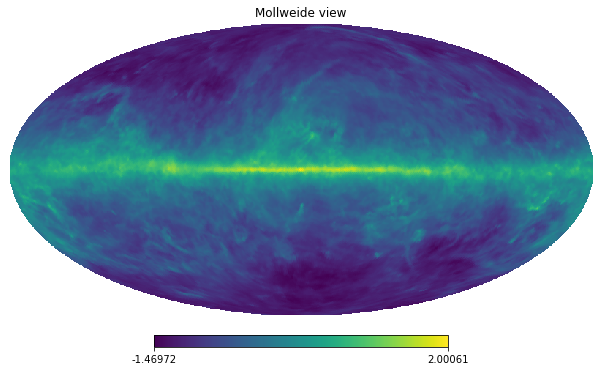

In [15]:
I_353_128 = hp.ud_grade(I_353,128)
hp.mollview(np.log10(I_353_128))

### Write to file

In [16]:
hp.write_map('I_353.fits', I_353_128, overwrite=True)

# IV. Radiance Map

### Read in radiace map

In [24]:
rad = hp.read_map('COM_CompMap_Dust-GNILC-Radiance_2048_R2.00.fits', verbose=False)

### Smooth map to 1 degree resolution
Note that the GNILC map is multi-resolution, so we choose the lowest resolution of 21.8' corresponding to diffuse, high latitude sightlines.

In [25]:
fwhm_in = (21.8/60.)*np.pi/180. # 21.8' in radians
fwhm_out = 1.*np.pi/180. # 1 deg in radians
fwhm_smooth = np.sqrt(fwhm_out**2 - fwhm_in**2)

rad = hp.smoothing(rad, fwhm_smooth)

### Downgrade to N<sub>side</sub> = 128
Initial pixellization is N<sub>side</sub> = 2048

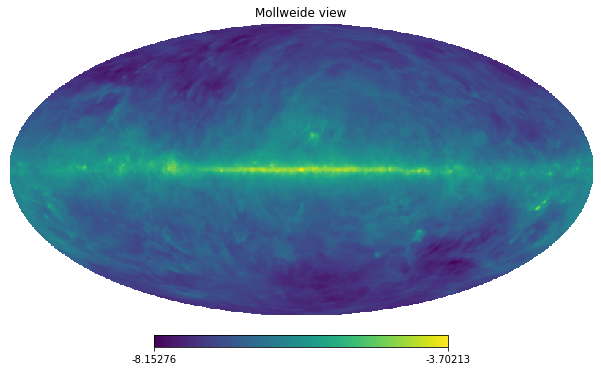

In [26]:
rad_128 = hp.ud_grade(rad,128)
hp.mollview(np.log10(rad_128))

### Write to file

In [27]:
hp.write_map('radiance.fits', rad_128, overwrite=True)

# V. N(HI) Map

### Read in N(HI) map from HI4Pi presented in Lenz et al. 2017

In [29]:
nhi = hp.read_map('mom0_-90_90_1024.hpx.fits')

/Users/clairemurray/anaconda3/lib/python3.8/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 1024
  warnings.warn("NSIDE = {0:d}".format(nside))


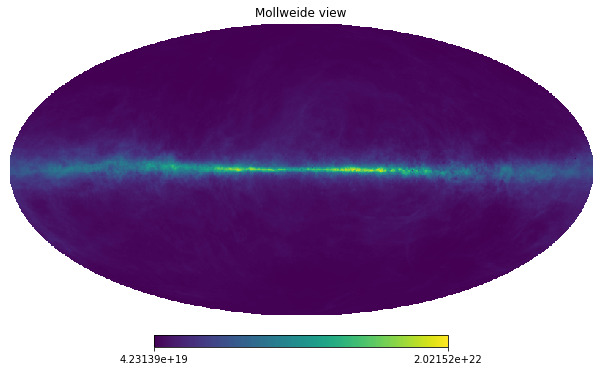

In [30]:
hp.mollview(nhi)

### Smooth map to 1 degree resolution

In [35]:
fwhm_in = (16.1/60.)*np.pi/180. # 16.1' in radians
fwhm_out = 1.*np.pi/180. # 1 deg in radians
fwhm_smooth = np.sqrt(fwhm_out**2 - fwhm_in**2)

nhi = hp.smoothing(nhi, fwhm_smooth)

/Users/clairemurray/anaconda3/lib/python3.8/site-packages/healpy/sphtfunc.py:822: UserWarning: Sigma is 24.545216 arcmin (0.007140 rad) 
  warnings.warn(
/Users/clairemurray/anaconda3/lib/python3.8/site-packages/healpy/sphtfunc.py:827: UserWarning: -> fwhm is 57.799567 arcmin
  warnings.warn(


### Downgrade to N<sub>side</sub> = 128
Initial pixellization is N<sub>side</sub> = 1024

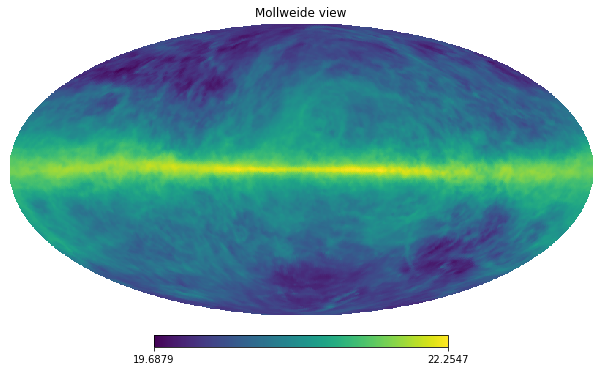

In [36]:
nhi_128 = hp.ud_grade(nhi,128)
hp.mollview(np.log10(nhi_128))

### Write to file

In [37]:
hp.write_map('nhi_hi4pi_hpx_128.fits', nhi_128, overwrite=True)

# VI. CNM Maps

### Read in fCNM and R_HI maps at original resolution in healpix format

In [62]:
fcnm = hp.read_map('fcnm_hi4pi_hpx.fits')
rhi = hp.read_map('rhi_hi4pi_hpx.fits')

### Smooth map with Gaussian FWHM to 1degree, downgrade to nside=128

In [63]:
# Compute smoothing kernel to convert between HI4Pi resolution (16.1') and 1 degree resolution (60'), in units of radians
hi4pi_kernel = np.sqrt(60**2- 16.1**2) / 60. * np.pi/180.

fcnm[np.isnan(fcnm)] = 0.
rhi[np.isnan(rhi)] = 1.

fcnm_sm = hp.sphtfunc.smoothing(fcnm, fwhm=hi4pi_kernel) 
rhi_sm = hp.sphtfunc.smoothing(rhi, fwhm=hi4pi_kernel) 

### Downgrade to N<sub>side</sub> = 128
Initial pixellization is N<sub>side</sub> = 1024

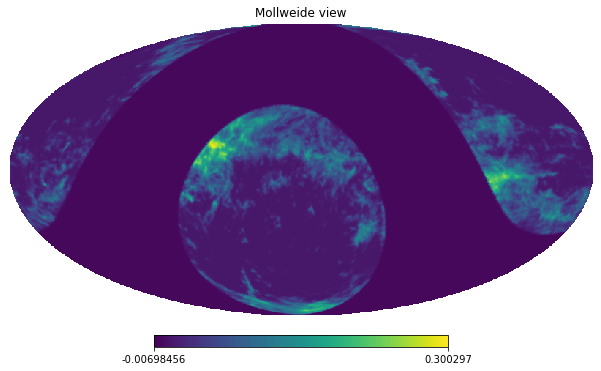

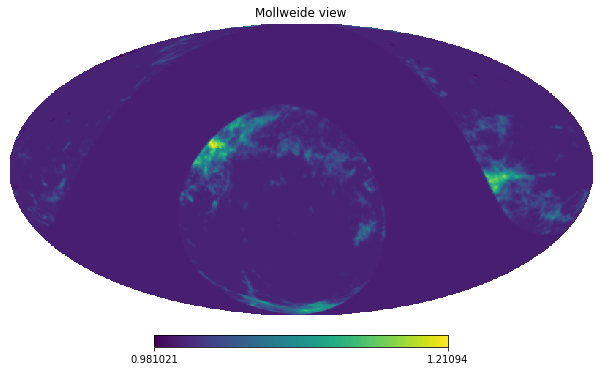

In [64]:
fcnm_128 = hp.ud_grade(fcnm_sm,128)
rhi_128 = hp.ud_grade(rhi_sm,128)
hp.mollview(fcnm_128)
hp.mollview(rhi_128)

### Change coordinates to Galactic frame

In [65]:
def change_coord(m, coord):
    """ Change coordinates of a HEALPIX map

    Parameters
    ----------
    m : map or array of maps
      map(s) to be rotated
    coord : sequence of two character
      First character is the coordinate system of m, second character
      is the coordinate system of the output map. As in HEALPIX, allowed
      coordinate systems are 'G' (galactic), 'E' (ecliptic) or 'C' (equatorial)

    Example
    -------
    The following rotate m from galactic to equatorial coordinates.
    Notice that m can contain both temperature and polarization.
    >>>> change_coord(m, ['G', 'C'])
    """
    # Basic HEALPix parameters
    npix = m.shape[-1]
    nside = hp.npix2nside(npix)
    ang = hp.pix2ang(nside, np.arange(npix))

    # Select the coordinate transformation
    rot = hp.Rotator(coord=reversed(coord))

    # Convert the coordinates
    new_ang = rot(*ang)
    new_pix = hp.ang2pix(nside, *new_ang)

    return m[..., new_pix]

In [66]:
fcnm_128_gal = change_coord(fcnm_128, ['C','G'])
rhi_128_gal = change_coord(rhi_128, ['C','G'])

### Mask pixels with |b|<30

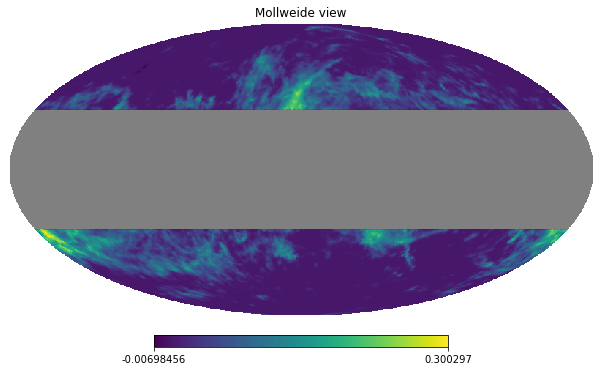

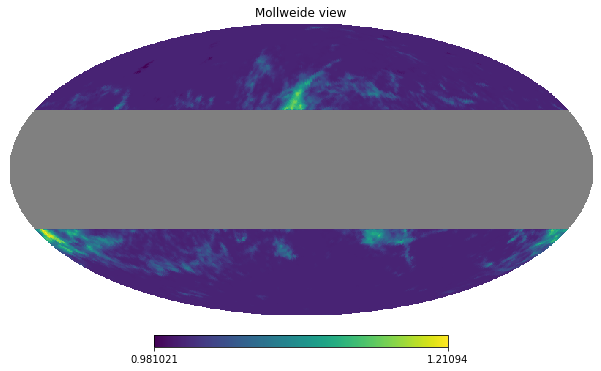

In [67]:
blimit = 30.
hpc = HEALPix(nside=128, order='RING', frame=Galactic())
hpc_coords = hpc.healpix_to_skycoord([np.arange(len(fcnm_128))])
lats = hpc_coords.galactic.b.degree
spots = np.squeeze(np.abs(lats)<blimit)

fcnm_128_gal[spots] = np.nan
rhi_128_gal[spots] = np.nan

hp.mollview(fcnm_128_gal)
hp.mollview(rhi_128_gal)

### Write to file

In [68]:
hp.write_map('fcnm_hi4pi_hpx_128.fits', fcnm_128_gal, overwrite=True)
hp.write_map('rhi_hi4pi_hpx_128.fits', rhi_128_gal, overwrite=True)